In [68]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

import matplotlib.lines as mlines

import os, sys
from pathlib import Path

import datetime
import math

import spotpy

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (21, 12)
plt.rcParams['font.family'] = 'sans-serif'

import seaborn as sns  # type: ignore
sns.set(style="darkgrid")

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [69]:
cb_paths = os.path.join(os.getcwd(), 'data/results')

algorithms = ['MC','LHS','DEMCZ','ROPE']
models = ['pori3','hwsd','isric1km','isric10km', 'isric5km','isric250m']

results=[]
result_names=[]
for algorithm in algorithms:
    for model in models:
        db_name = os.path.join(cb_paths, f"{model}_{algorithm}_1000")
        fname = str(db_name) + ".csv"
        print(fname)
        if os.path.isfile(fname):
            result_names.append(f"{model}_{algorithm}_1000")
            results.append(spotpy.analyser.load_csv_results(db_name))
            

C:\dev\build\pyswat_scripting\data/results\pori3_MC_1000.csv
C:\dev\build\pyswat_scripting\data/results\hwsd_MC_1000.csv
C:\dev\build\pyswat_scripting\data/results\isric1km_MC_1000.csv
C:\dev\build\pyswat_scripting\data/results\isric10km_MC_1000.csv
C:\dev\build\pyswat_scripting\data/results\isric5km_MC_1000.csv
C:\dev\build\pyswat_scripting\data/results\isric250m_MC_1000.csv
C:\dev\build\pyswat_scripting\data/results\pori3_LHS_1000.csv
C:\dev\build\pyswat_scripting\data/results\hwsd_LHS_1000.csv
C:\dev\build\pyswat_scripting\data/results\isric1km_LHS_1000.csv
C:\dev\build\pyswat_scripting\data/results\isric10km_LHS_1000.csv
C:\dev\build\pyswat_scripting\data/results\isric5km_LHS_1000.csv
C:\dev\build\pyswat_scripting\data/results\isric250m_LHS_1000.csv
C:\dev\build\pyswat_scripting\data/results\pori3_DEMCZ_1000.csv
C:\dev\build\pyswat_scripting\data/results\hwsd_DEMCZ_1000.csv
C:\dev\build\pyswat_scripting\data/results\isric1km_DEMCZ_1000.csv
C:\dev\build\pyswat_scripting\data/results

In [70]:
len(results)

24

In [66]:
from pyswat import SimManage, ReadOut, FileEdit

class swat_callib_setup(object):
    def __init__(
        self, swat_model, observed_data, param_defs, parallel="seq", temp_dir=None
    ):

        self.model = swat_model
        self.observed_data = observed_data

        self.params = []
        for i in range(len(param_defs)):
            self.params.append(
                spotpy.parameter.Uniform(
                    name=param_defs[i][0],
                    low=param_defs[i][1],
                    high=param_defs[i][2],
                    optguess=np.mean([param_defs[i][1], param_defs[i][2]]),
                )
            )

        self.temp_dir = temp_dir
        self.parallel = parallel

        if self.parallel == "seq":
            pass

        if self.parallel == "mpi":

            from mpi4py import MPI

            comm = MPI.COMM_WORLD
            self.mpi_size = comm.Get_size()
            self.mpi_rank = comm.Get_rank()

    def onerror(self, func, path, exc_info):
        import stat

        if not os.access(path, os.W_OK):
            # Is the error an access error ?
            os.chmod(path, stat.S_IWUSR)
            func(path)
        else:
            raise

    def prep_temp_model_dir(self):
        temp_id = uuid.uuid1()

        if self.parallel == "mpi":
            try:
                temp_id = f"mpi{self.mpi_rank}_" + str(temp_id)
            except NameError:
                pass

        test_path = f"swat_{temp_id}"

        if self.temp_dir is None:
            test_path = Path(os.path.join(os.getcwd(), test_path))
        else:
            test_path = Path(os.path.join(self.temp_dir, test_path))

        if os.path.exists(test_path):
            print("Deleting temp folder " + str(test_path))
            shutil.rmtree(test_path, onerror=self.onerror)

        print("Copying model to folder " + str(test_path))
        shutil.copytree(self.model.working_dir, test_path)

        try:
            m = SimManage.SwatModel.loadModelFromDirectory(test_path)
            if m.is_runnable() == 0:
                m.swat_exec = self.model.swat_exec
            return m
        except ValueError:
            m = SimManage.SwatModel.initFromTxtInOut(test_path, copy=False, force=True)
            if m.is_runnable() == 0:
                m.swat_exec = self.model.swat_exec
            return m

    def remove_temp_model_dir(self, model):
        try:
            print("Deleting temp folder " + str(model.working_dir))
            shutil.rmtree(model.working_dir, onerror=self.onerror)
        except Exception as e:
            print(e)
            traceback.print_exc(file=sys.stdout)
            print("Error deleting tmp model run")
            pass

    def manipulate_model_params(self, model, parameters):

        print(f"this iteration's parameters:")
        print(parameters)
        # print(self.params[0].name)
        # print(parameters['v__SFTMP__bsn'])

        how_apply = {"v": "s", "r": "*", "a": "+"}

        for idx, param_string in enumerate(self.params):
            # print(param_string.name)
            # print(idx)
            # print(len(param_string.name))
            # print(parameters[idx])

            # slice the stringname open
            # how  param  manipu   1        2         3          4         5   (times __)
            # orig: x__<parname>.<ext>__<hydrp>__<soltext>__<landuse>__<subbsn>__<slope>
            # [0] split ('.')  split ('__') [0]  how v_s r_* a_+  [1] param field name
            # ---
            # [1] split('__') [0] manipulator/file type [1] hydgrp ... etc
            # only __ double underscore
            # how  param  manipu   3        4          5          6         7   (times __)
            # x__<parname>__<ext>__<hydrp>__<soltext>__<landuse>__<subbsn>__<slope>

            field_list = param_string.name.split("__")
            how = field_list[0]
            param_field = field_list[1]
            manip_ext = field_list[2]
            if len(field_list) > 3:
                hydrp = field_list[3]
            if len(field_list) > 4:
                soltext = field_list[4]
            if len(field_list) > 5:
                landuse = field_list[5]
            if len(field_list) > 6:
                subbsn = field_list[6]
            if len(field_list) > 7:
                slope = field_list[7]

            changeHow = how_apply[how]

            print(
                f"field {param_field} in file/manip {manip_ext} will be changed via '{changeHow}' and value {parameters[idx]} "
            )
            if len(field_list) > 3:
                print(f"ignored constraints ({field_list[2:]})")

            manipulator_handle = model.getFileManipulators()[manip_ext]

            # here we could add addtional conditions for finer granularity
            for m in manipulator_handle:
                m.setChangePar(param_field, parameters[idx], changeHow)
                m.finishChangePar()

    def parameters(self):
        return spotpy.parameter.generate(self.params)

    # provide the available observed data
    def evaluation(self):
        # observations = [self.observed_data]
        return self.observed_data

    # Simulation function must not return values besides for which evaluation values/observed data are available
    def simulation(self, parameters):
        the_model = self.prep_temp_model_dir()
        the_model.enrichModelMeta(verbose=False)
        if the_model.is_runnable() == 0:
            print(f"{the_model.swat_exec} is NOT runnable: {the_model.is_runnable()}")

        self.manipulate_model_params(the_model, parameters)

        # TODO: edit the correct parameters in SWAT files

        ret_val = the_model.run(capture_logs=False, silent=False)
        print(f"returns {ret_val} - vs {the_model.last_run_succesful}")
        # print(model4.last_run_logs)

        reach = 1
        # simulated data
        reader1 = ReadOut.rchOutputManipulator(
            ["FLOW_OUT"],
            [reach],
            "skip",
            True,
            0,
            the_model.working_dir,
            iprint="month",
            stats_dir=self.temp_dir,
        )
        sim_flow_1 = reader1.outValues["FLOW_OUT"][reach]

        # cleanup
        self.remove_temp_model_dir(the_model)
        return sim_flow_1

    # if we want to minimize our function, we can select a negative objective function
    def objectivefunction(self, simulation, evaluation):
        print("simulation")
        print(len(simulation))
        print("evaluation")
        print(len(evaluation))

        objectivefunction = spotpy.objectivefunctions.nashsutcliffe(
            evaluation, simulation
        )
        return objectivefunction


obs_filename = os.path.join('data', os.path.join("observed", "pori_flow_monthly_2003-2010.txt"))
f = open(obs_filename, "r")
lines = f.readlines()
f.close()
measured = []
for i in lines:
    measured.append(i.split(";")[2].strip())

obs = np.array([float(i) for i in measured])

obs_masked = np.ma.masked_where(obs == -9999.0, obs)
model4 = {}

try:
    model4 = SimManage.SwatModel.initFromTxtInOut(
        txtInOut=os.path.join(os.getcwd(), os.path.join("data", "TxtInOut")),
        copy=True,
        target_dir="demo_callib2",
        force=False,
    )
except ValueError:
    model4 = SimManage.SwatModel.loadModelFromDirectory("demo_callib2")

par_file_name = os.path.join('data', os.path.join("params", "pori3_par_inf_spotpy.txt"))
print(f"loading parameter file {par_file_name}")

dtype = [("f0", "|U30"), ("f1", "<f8"), ("f2", "<f8")]
par_file_load = np.genfromtxt(par_file_name, dtype=dtype, encoding="utf-8")

spot_setup = swat_callib_setup(
        model4, obs_masked, par_file_load, parallel='seq', temp_dir='temp_dir'
    )

demo_callib2 exists ... 
not empty and no force overwrite, aborting!
demo_callib2 exists ... 
{'swat_version': '2012', 'working_dir': 'C:\\dev\\build\\pyswat_scripting\\demo_callib2', 'metadata_obj': '.swatmodel.json', 'swat_exec': 'C:\\dev\\build\\pyswat_scripting\\demo_callib2\\swat_64rel.exe', 'model_text_encoding': 'latin-1', 'n_sub_basins': 53, 'n_hru': 441, 'n_years_simulated': 14, 'beginning_year_simulation': 2000, 'outprint_code': 0, 'n_years_skip': 3, 'n_days_skip': 1096, 'readout_years': 11, 'readout_days': 4382}
{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}
model text encoding unlikely, assuming latin-1
C:\dev\build\pyswat_scripting\demo_callib2\swat_64rel.exe is executable
C:\dev\build\pyswat_scripting\demo_callib2\swat_64rel.exe is executable
loading parameter file data\params\pori3_par_inf_spotpy.txt


In [71]:
counter=0
for db in result_names:
    print("------------------------------ ################### -------------------")
    print(result_names[counter])
    best_params = spotpy.analyser.get_best_parameterset(results[counter])
    max_idx = spotpy.analyser.get_maxlikeindex(results[counter])
    print(f"{max_idx}")
    
    evaluation = obs_masked
    
    # post = spotpy.analyser.get_posterior(results[counter], percentage=10)
    # perc = spotpy.analyser.get_percentiles(results[counter])
    
    # spotpy.analyser.plot_parameter_uncertainty(post, evaluation, fig_name = f"{result_names[counter]}_Posterior_parameter_uncertainty.png")
    # spotpy.analyser.plot_objectivefunction(results[counter], evaluation, limit=None, sort = True, fig_name = f"{result_names[counter]}_objective_function.png")
    # spotpy.analyser.plot_parametertrace(results[counter], parameternames=['v__SFTMP__bsn', 'v__SMFMN__bsn', 'v__SMFMX__bsn', 'v__SMTMP__bsn', 'v__SNO50COV__bsn', 'v__SNOCOVMX__bsn'], fig_name = f"{result_names[counter]}_Parameter_trace.png")
    
    counter+=1

------------------------------ ################### -------------------
pori3_MC_1000
Best parameter set:
r__CH_N2__rte=0.1335, v__ALPHA_BNK__rte=0.1405, v__GWQMN__gw=5.656, r__ALPHA_BF__gw=-0.005493, v__SFTMP__bsn=-2.186, v__SMTMP__bsn=1.325, v__SNOCOVMX__bsn=48.94, v__SNO50COV__bsn=0.3923, v__GW_DELAY__gw=14.77, v__GW_REVAP__gw=0.095, v__REVAPMN__gw=6.074, a__RCHRG_DP__gw=0.00939, r__CN2__mgt=-0.1008, r__SOL_CRK__sol=-0.03595, r__SOL_BD__sol=-0.1571, r__SOL_AWC__sol=0.01544, r__SOL_K__sol=5.23, r__OV_N__hru=-0.02203, v__LAT_TTIME__hru=60.8, r__SLSOIL__hru=-0.0348, r__CANMX__hru=-0.008, v__ESCO__hru=0.8574, v__EPCO__hru=0.5884, v__CH_K1__sub=2.547, v__CH_N1__sub=0.01903, v__SURLAG__bsn=-5.547, v__SMFMX__bsn=10.88, v__SMFMN__bsn=2.648
Run number 49 has the highest objectivefunction with: -1.035
((array([ 49, 217, 387], dtype=int64),), -1.035)
------------------------------ ################### -------------------
hwsd_MC_1000
Best parameter set:
a__RCHRG_DP__gw=0.02043, r__CANMX__hru=-0.

------------------------------ ################### -------------------
hwsd_MC_1000
Run number 186 has the highest objectivefunction with: -1.064
((array([186, 716, 725], dtype=int64),), -1.064)
Ttest_indResult(statistic=-3455.0298983691814, pvalue=0.0)
like1 is signifikant different to like2: p<0.05
A plot of the best model run has been saved as hwsd_MC_1000_Best_model_run.png
The figure as been saved as hwsd_MC_1000_regressionanalysis.png
------------------------------ ################### -------------------
isric10km_MC_1000
Run number 152 has the highest objectivefunction with: -0.9697
((array([152], dtype=int64),), -0.9697)
Ttest_indResult(statistic=-2873.6138442864703, pvalue=0.0)
like1 is signifikant different to like2: p<0.05
A plot of the best model run has been saved as isric10km_MC_1000_Best_model_run.png
The figure as been saved as isric10km_MC_1000_regressionanalysis.png
------------------------------ ################### -------------------
isric5km_MC_1000
Run number 733 

C:\dev\conda3\envs\daskgeo2020a\lib\site-packages\spotpy\analyser.py:785: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig= plt.figure(figsize=(16,9))


A plot of the best model run has been saved as isric5km_DEMCZ_1000_Best_model_run.png


C:\dev\conda3\envs\daskgeo2020a\lib\site-packages\spotpy\analyser.py:908: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(16,9))


The figure as been saved as isric5km_DEMCZ_1000_regressionanalysis.png


IndexError: list index out of range

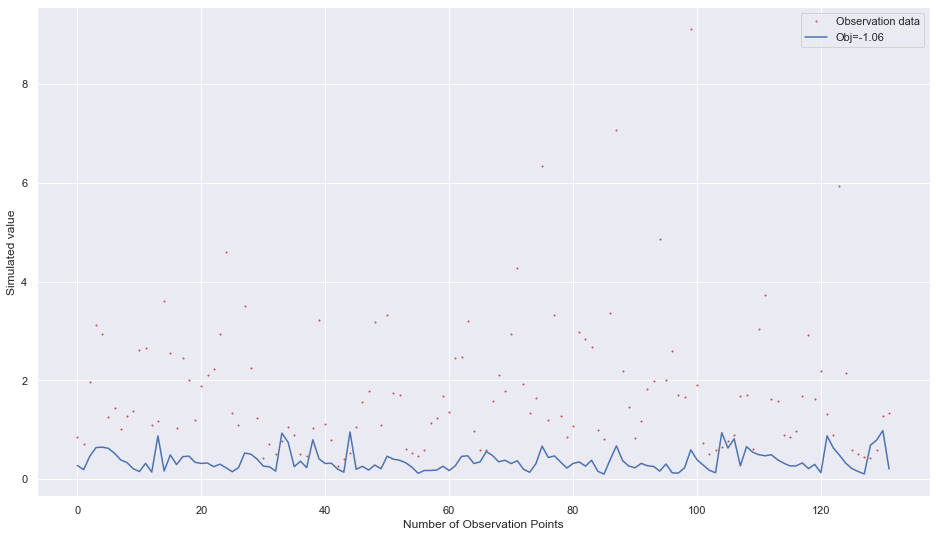

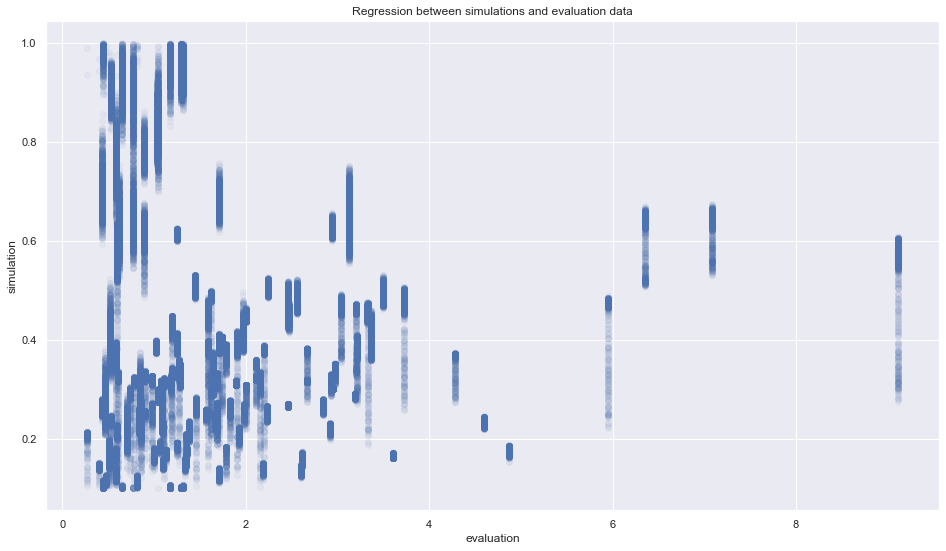

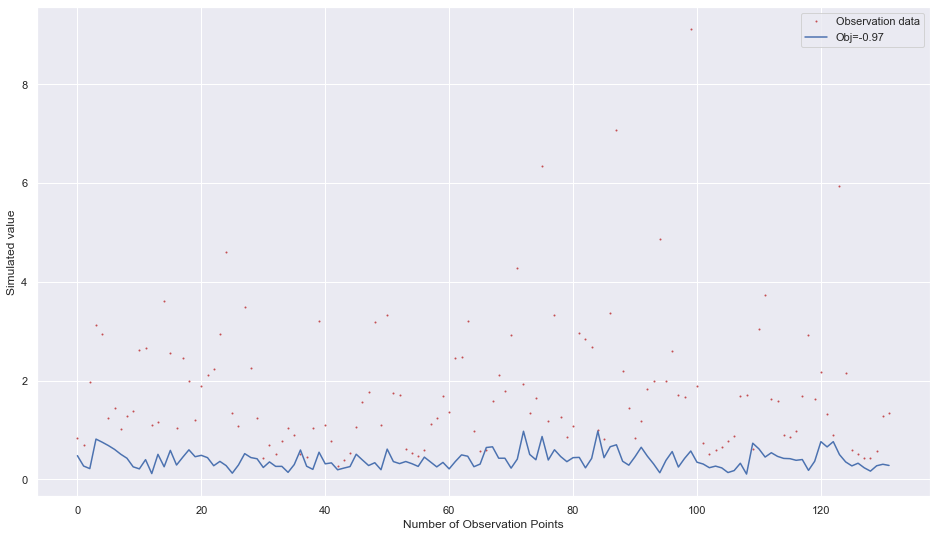

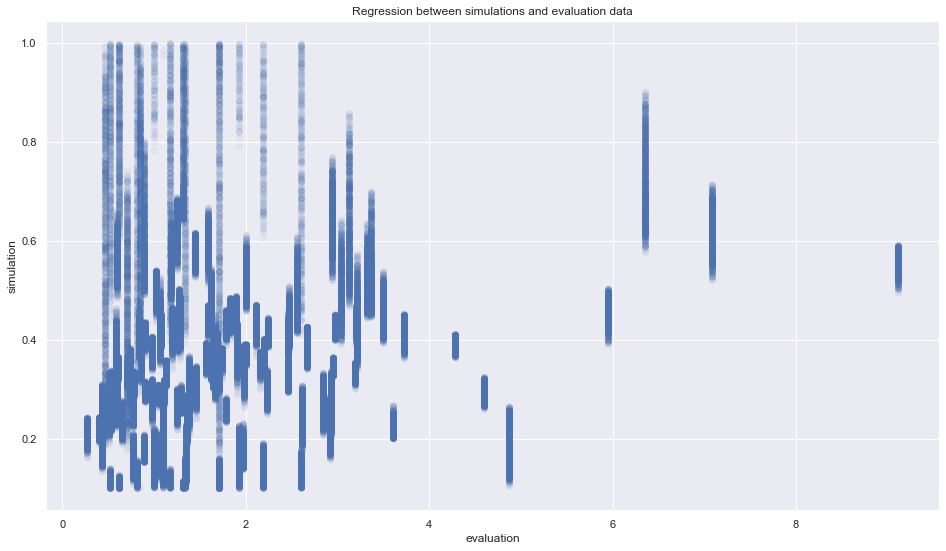

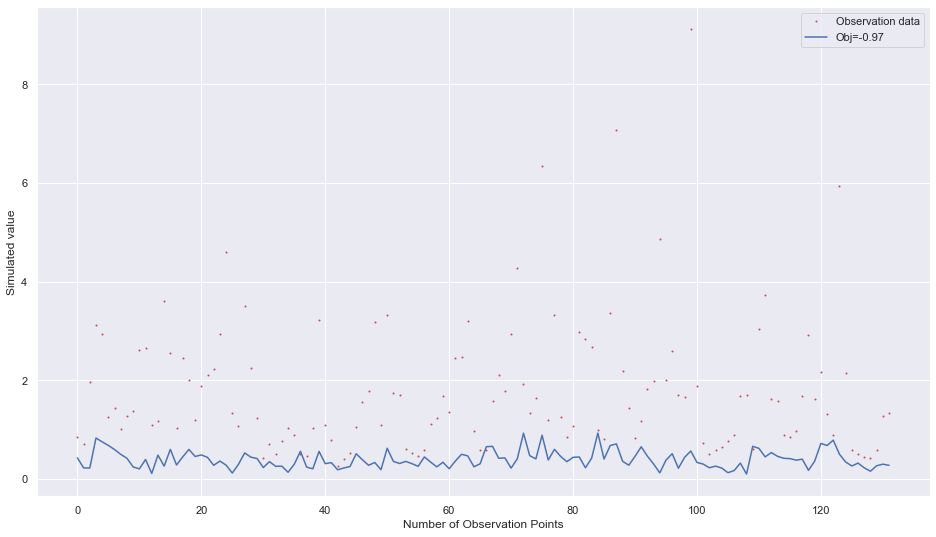

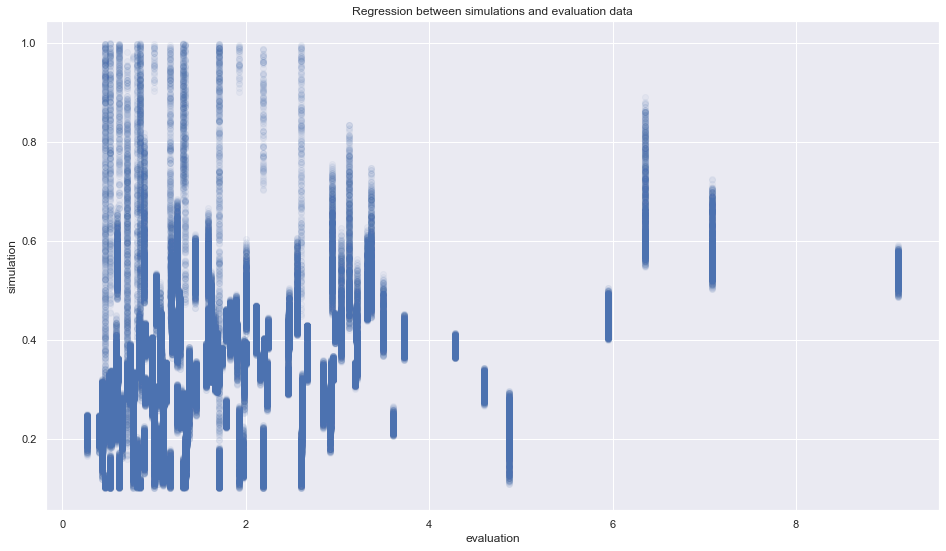

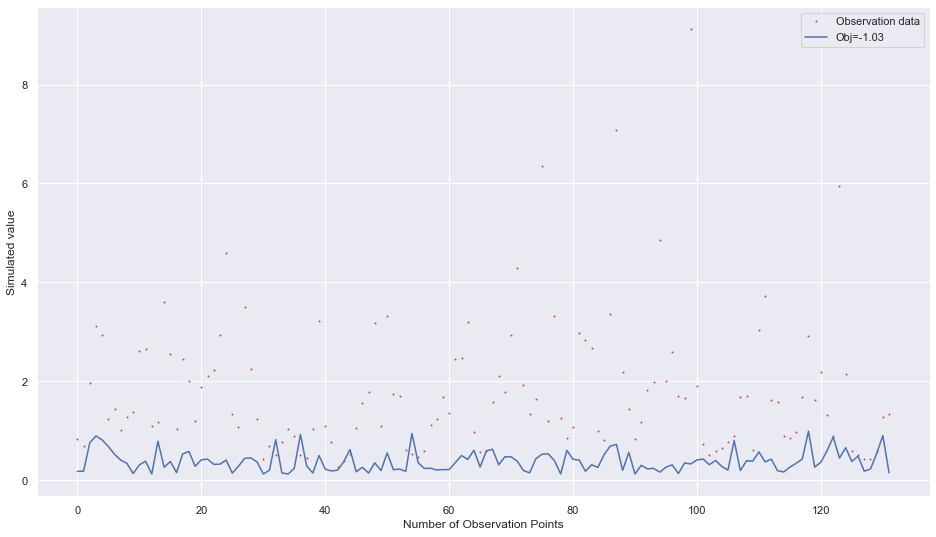

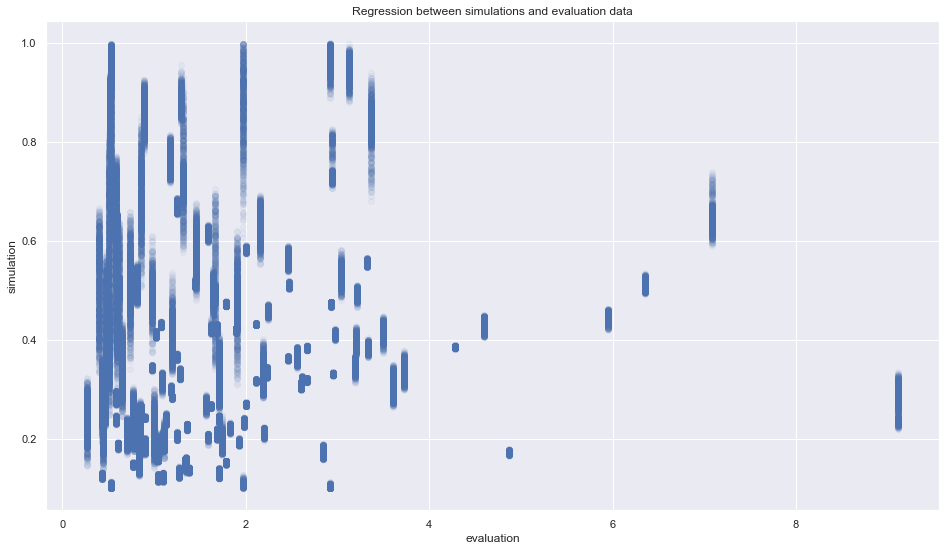

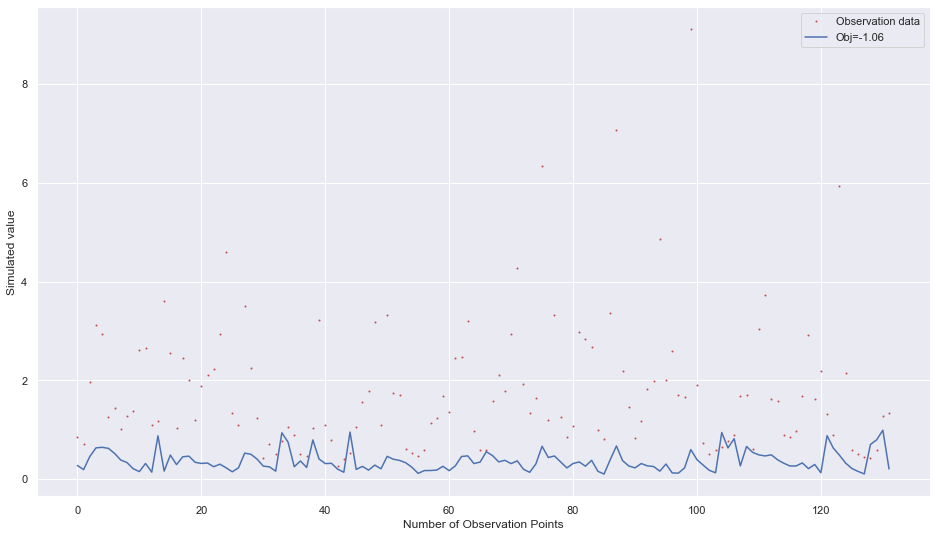

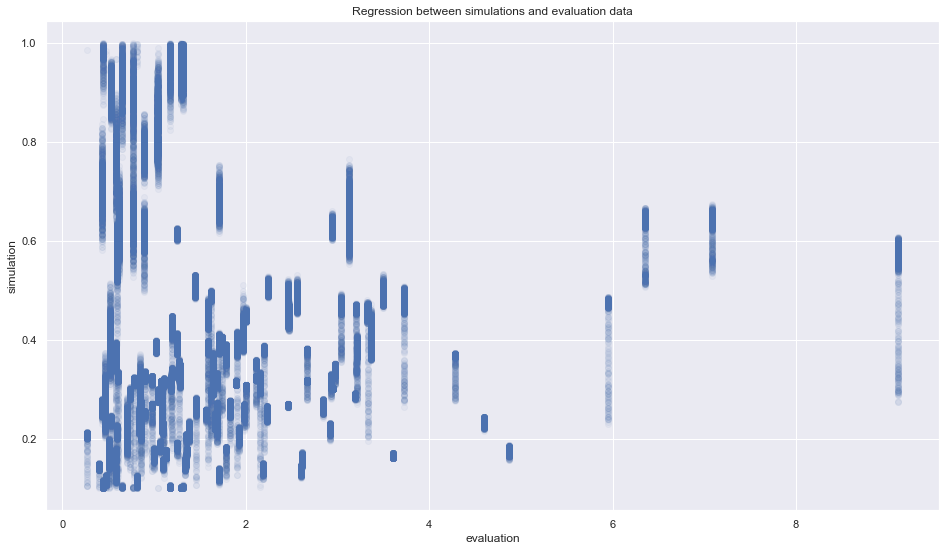

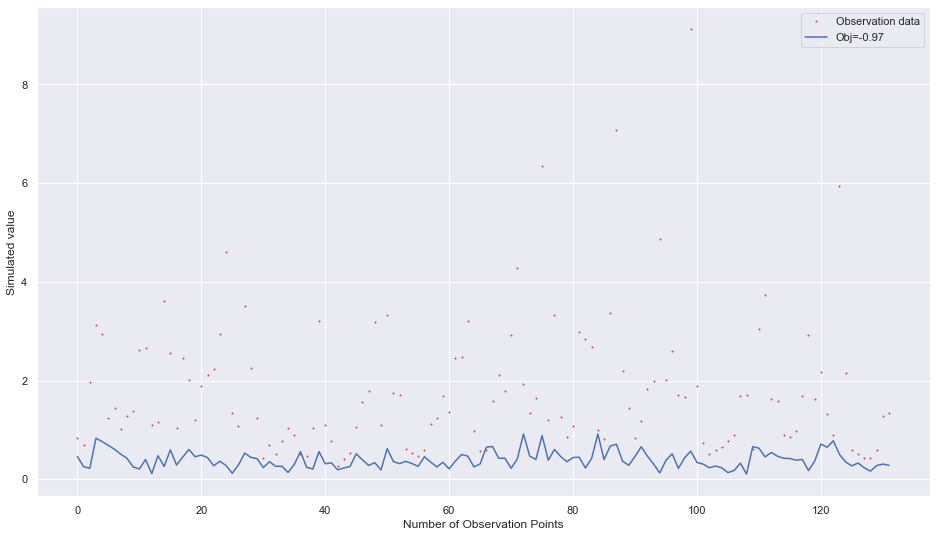

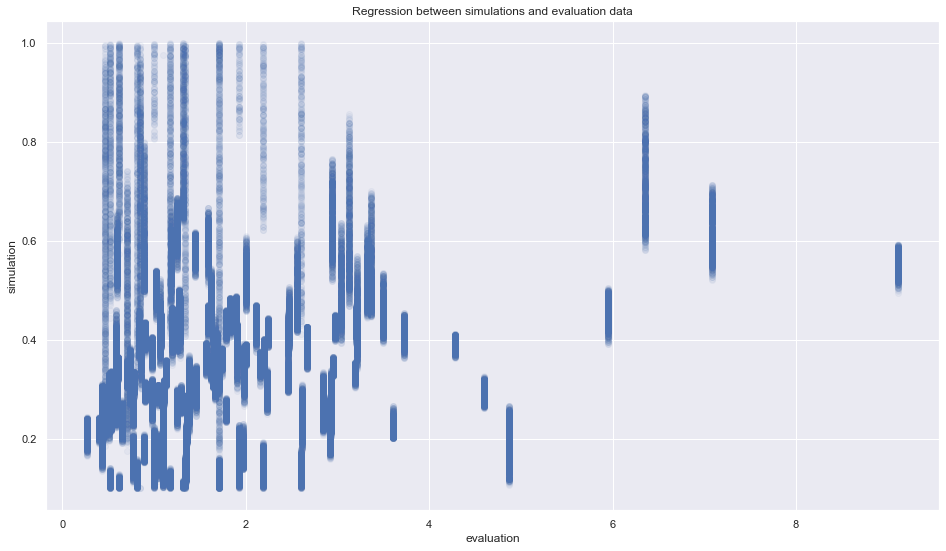

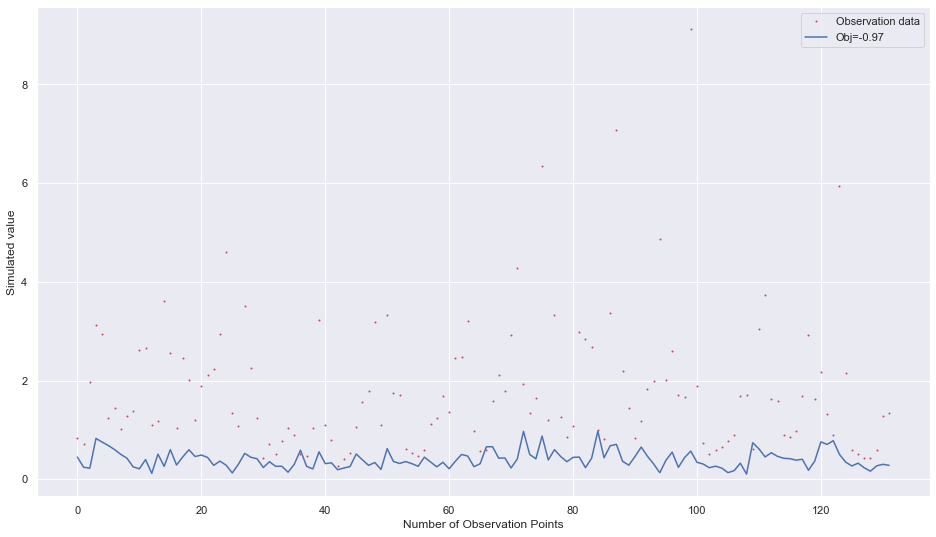

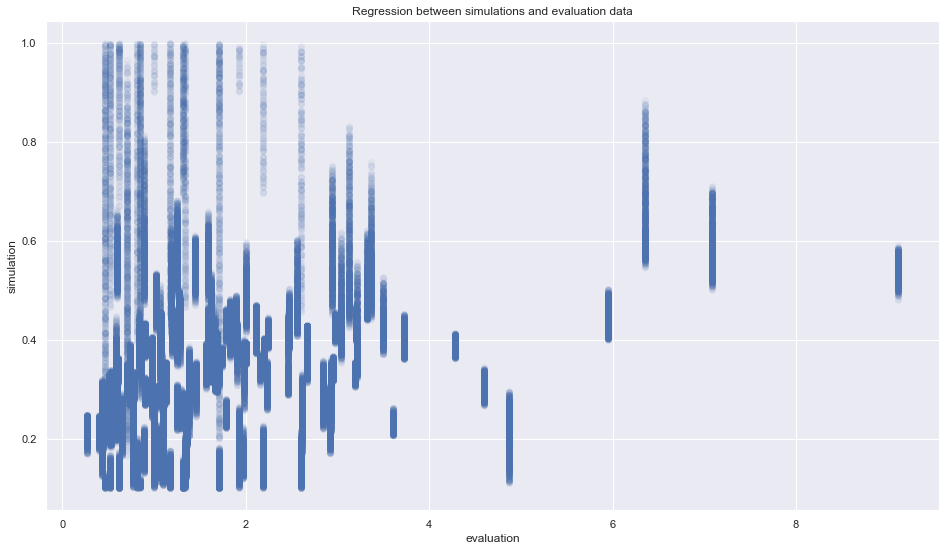

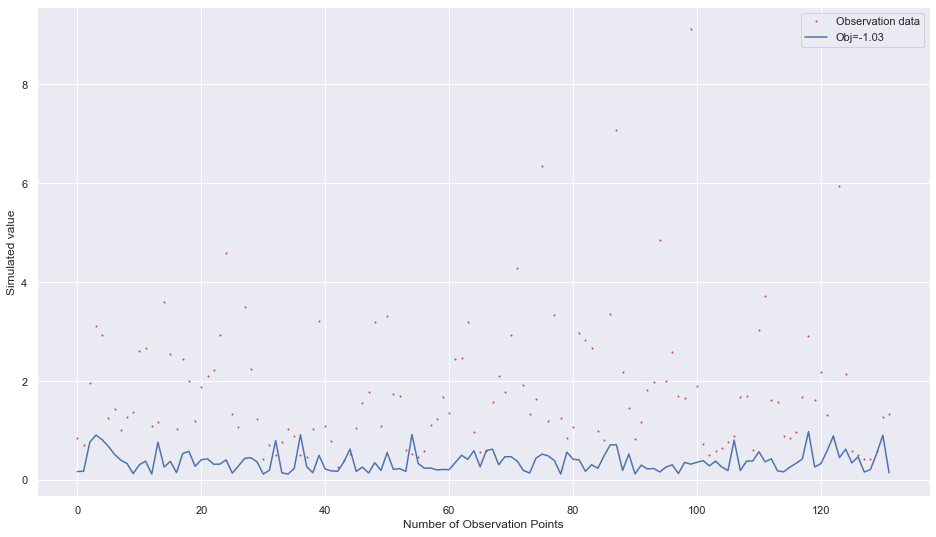

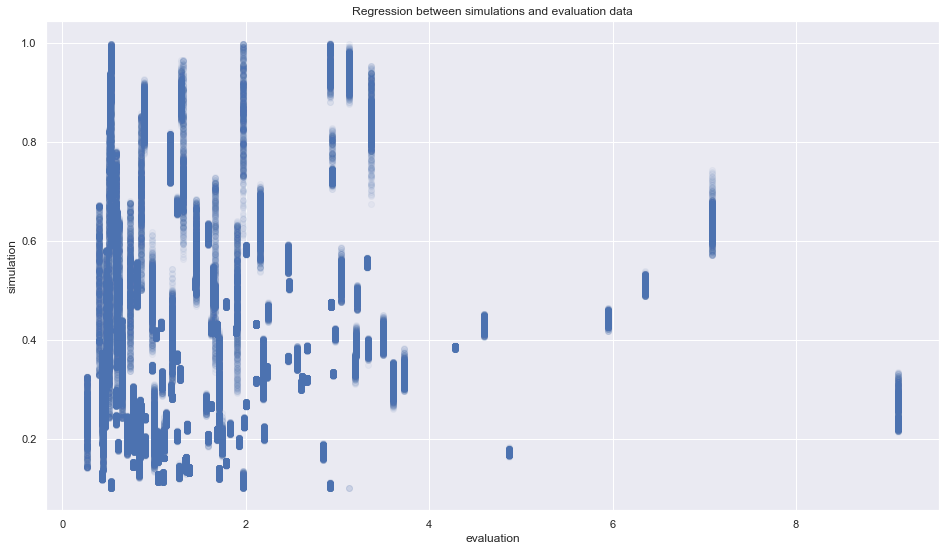

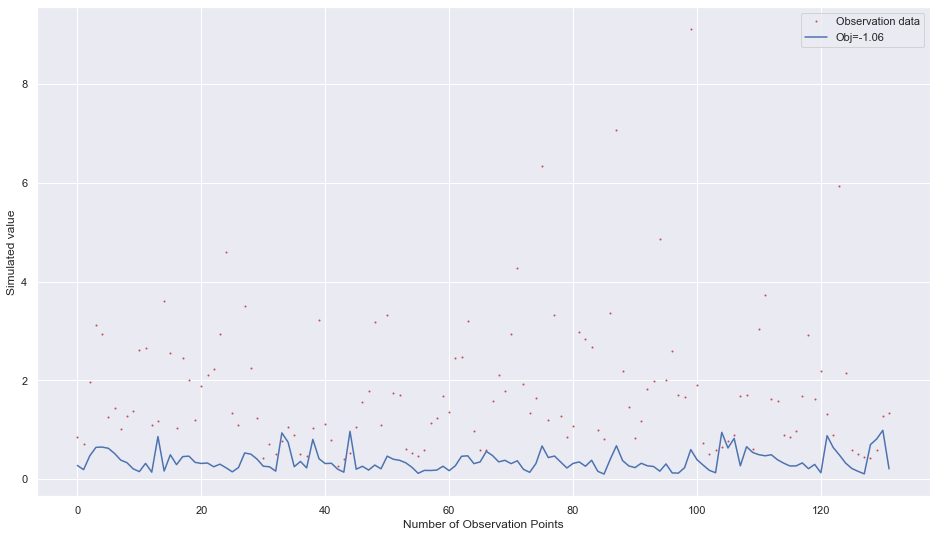

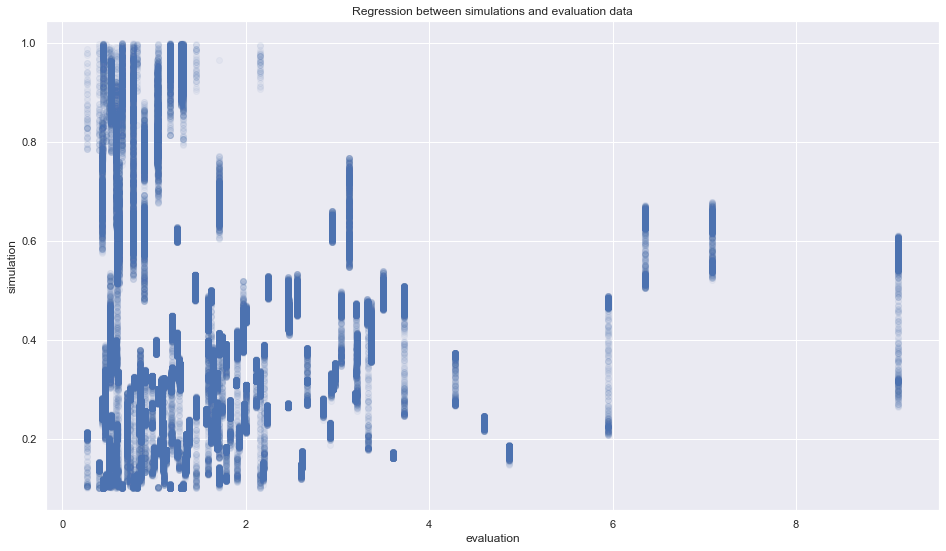

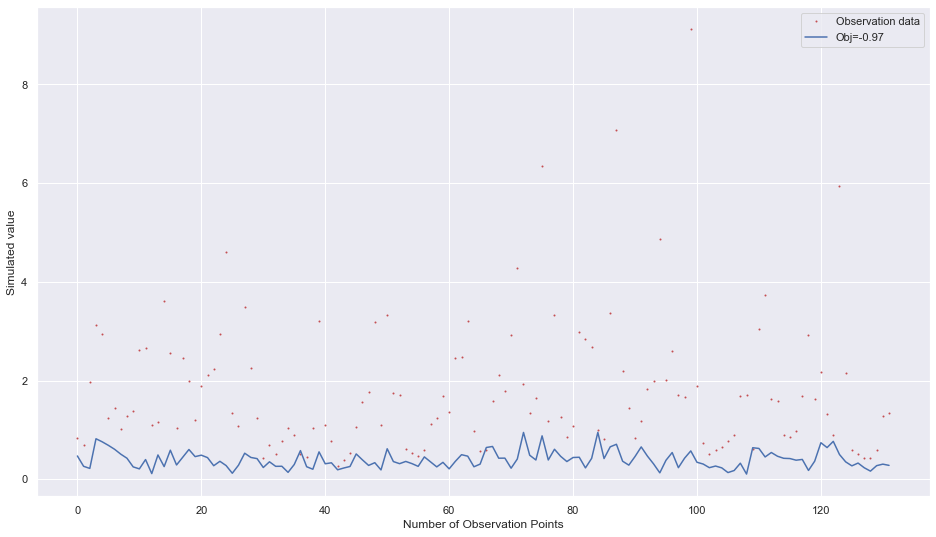

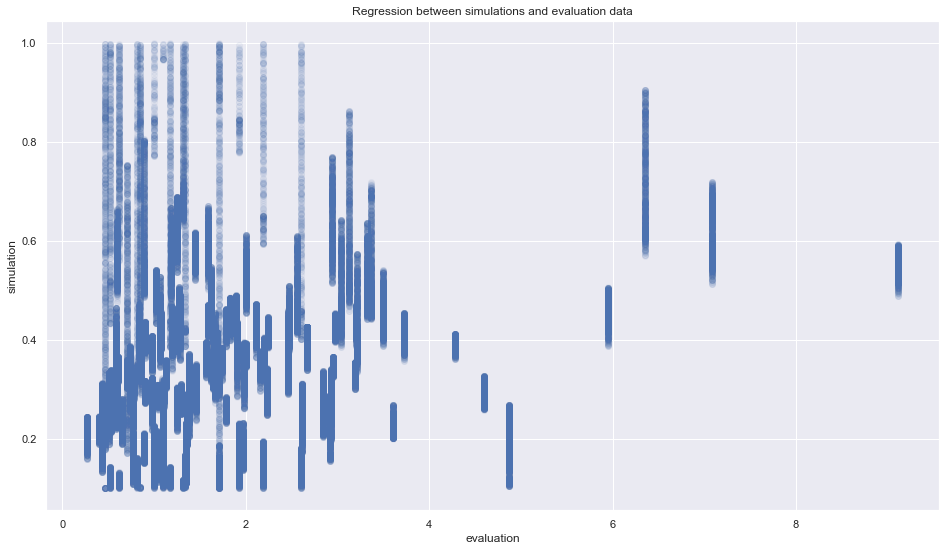

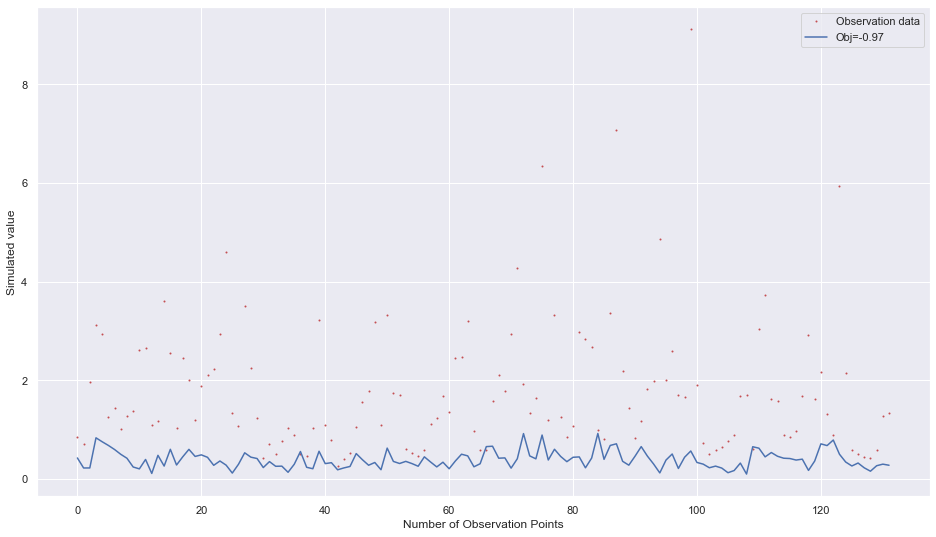

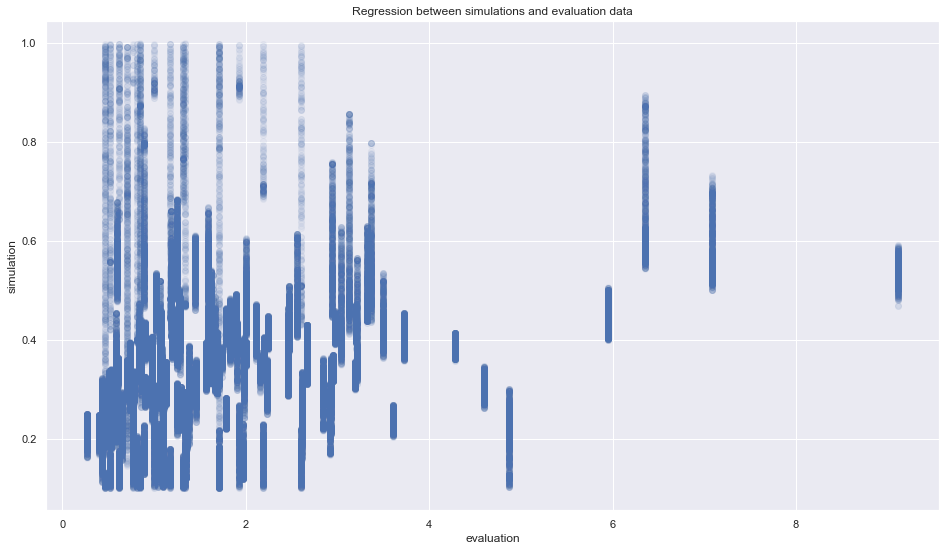

In [46]:
counter=0
for db in result_names:
    print("------------------------------ ################### -------------------")
    print(result_names[counter])
    max_idx = spotpy.analyser.get_maxlikeindex(results[counter])
    print(f"{max_idx}")
    
    evaluation = obs_masked
    
    like1 = results[counter]['like1']
    like2 = spotpy.analyser.calc_like(results[counter],evaluation,spotpy.objectivefunctions.rmse)
    
    spotpy.analyser.compare_different_objectivefunctions(like1,like2)
    
    spotpy.analyser.plot_bestmodelrun(results[counter],evaluation,fig_name =f"{result_names[counter]}_Best_model_run.png")
    spotpy.analyser.plot_regression(results[counter],evaluation,fig_name=f"{result_names[counter]}_regressionanalysis.png")
    counter+=1

spotpy.analyser.plot_objectivefunctiontraces(results,evaluation,result_names,fig_name=f"{result_names[counter]}_Like_trace.png")

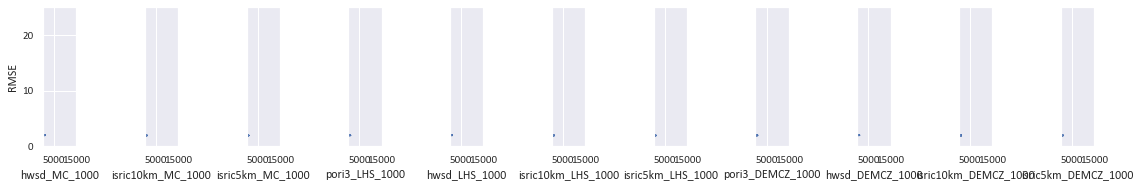

In [62]:
# spotpy.analyser.plot_objectivefunctiontraces(results[1],evaluation,result_names,fig_name=f"{result_names[counter]}_Like_trace.png")
fig_name=f"{result_names[0]}_Like_trace.png"

import matplotlib.pyplot as plt
from matplotlib import colors
cnames=list(colors.cnames)
font = {'family' : 'calibri',
    'weight' : 'normal',
    'size'   : 20}
plt.rc('font', **font)
fig=plt.figure(figsize=(16,3))
xticks=[5000,15000]

for i in range(len(results)):
    ax  = plt.subplot(1,len(results),i+1)
    likes=spotpy.analyser.calc_like(results[i],evaluation,spotpy.objectivefunctions.rmse)
    ax.plot(likes,'b-')
    ax.set_ylim(0,25)
    ax.set_xlim(0,len(results[0]))
    ax.set_xlabel(result_names[i])
    ax.xaxis.set_ticks(xticks)
    if i==0:
        ax.set_ylabel('RMSE')
        ax.yaxis.set_ticks([0,10,20])
    else:
        ax.yaxis.set_ticks([])

plt.tight_layout()
fig.savefig(fig_name)


In [50]:
len(results)

11

In [51]:
len(result_names)

11